In [ ]:
import pandas as pd
import numpy as np
from random import sample
import random
import torch
#from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import json

df= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Book Recommendation/trainwithzerostopredict.csv')
topredict= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Book Recommendation/topredict.csv')

df_train=df[df['Book-Rating']!=0] #training dataset 
df_numrating= df_train.groupby('User-ID').agg(Num_ratings=('Book-Rating','count')).reset_index()
df_numrating.sort_values(by=['Num_ratings'], ascending=False, inplace=True)

df_tune_usr= df_train[df_train['User-ID'].isin(df_numrating['User-ID'][:1000])].reset_index(drop=True) # tuning dataset
df_val= df_tune_usr.sample(frac=0.2, axis=0, random_state=42).reset_index().drop('index', axis=1) #20% validation dataset

df_val_zero= df_val.copy()
df_val_zero['Book-Rating']=0

#put zeros on ratings for validation dataset and create the whole matrix
df_mat= pd.concat([df_tune_usr,df_val_zero]).drop_duplicates(['User-ID','ISBN'],keep='last').sort_values('User-ID').reset_index(drop=True)

mat=df_mat.pivot(index='User-ID',columns='ISBN',values='Book-Rating') .fillna(0)
matrix= torch.tensor(mat.values)/10 #scale by 1/10

dict_user= dict(zip(sorted(set(df_tune_usr['User-ID'])),range(len(sorted(set(df_tune_usr['User-ID']))))))
dict_book= dict(zip(sorted(set(df_tune_usr['ISBN'])),range(len(sorted(set(df_tune_usr['ISBN']))))))
index1=[]
index2=[]
for i in range(len(df_val)):
  index1.append([dict_user[df_val['User-ID'][i]]])
  index2.append([dict_book[df_val['ISBN'][i]]])

indices= (torch.tensor(index1),torch.tensor(index1)) # indices to predict

In [ ]:
def val_loss(pred,target,indices):
  return torch.sqrt((1/len(indices[0]))*100*torch.sum(torch.square(target[indices]-pred[indices]))) #multiply by 100 because we scaled by 1/10

In [ ]:
def MF(M,k,max_it,lambd,mu):
    n=M.size()[0]
    m= M.size()[1]
    nonzero=len(M.nonzero())
    index= M.nonzero().split(1, dim=1)
    #param=torch.rand(n*k+k*m,dtype=float,requires_grad=True)
    param1=torch.rand((n,k),dtype=torch.float,requires_grad=True) # randomize U
    param2=torch.rand((k,m),dtype=torch.float,requires_grad=True) # randomize V

    opt1= torch.optim.Adam([param1],lr=0.1) #adam works better than SGD with momentum
    opt2= torch.optim.Adam([param2],lr=0.1)
    
    #scheduler1= ReduceLROnPlateau(opt1, 'min') 
    #scheduler2 = ReduceLROnPlateau(opt2, 'min')
    

    #def get_loss(params,params_hat):
        #return torch.sum(torch.square(params- params_hat))

    def run_iterations(max_it):
        loss_record=[]
        converged=False
        for it in tqdm(range(max_it)):
            if it%2==0:
                opt1.zero_grad(set_to_none=True)
                #torch.matmul(param[:n*k].reshape(n,k), pam[n*k:].reshape(k,m))
                loss=torch.sum(torch.square(torch.matmul(param1, param2)[index]- M[index])) + lambd*torch.sum(torch.square(param1))+mu*torch.sum(torch.square(param2))
                loss_record.append(loss.item())
                loss.backward()
                opt1.step()
                #scheduler1.step(loss)
            else:
                opt2.zero_grad(set_to_none=True)
                #torch.matmul(param[:n*k].reshape(n,k), pam[n*k:].reshape(k,m))
                loss=torch.sum(torch.square(torch.matmul(param1, param2)[index]- M[index])) + lambd*torch.sum(torch.square(param1))+mu*torch.sum(torch.square(param2))
                loss_record.append(loss.item())
                loss.backward()
                opt2.step()
                #scheduler2.step(loss)
        return torch.matmul(param1,param2), loss_record[-1]
    return run_iterations(max_it)

In [ ]:
val_losses={}
loss_records={}
for k in [5,10,20]:
  for lambd in [0.01,0.1]:
    for mu in [0.01,0.1]:
      pred_matrix, latest_loss = MF(matrix,k,800,lambd,mu)
      val_losses["k:{},lambda:{},mu:{}".format(k,lambd,mu)]= val_loss(pred_matrix,matrix,indices)
      loss_records["k:{},lambda:{},mu:{}".format(k,lambd,mu)]= latest_loss 

100%|██████████| 800/800 [02:23<00:00,  5.59it/s]


In [ ]:
val_losses

{'k:5,lambda:0.01,mu:0.01': tensor(189.7712, dtype=torch.float64, grad_fn=<SqrtBackward0>),
 'k:5,lambda:0.01,mu:0.1': tensor(4.9642, dtype=torch.float64, grad_fn=<SqrtBackward0>),
 'k:5,lambda:0.1,mu:0.01': tensor(72.4884, dtype=torch.float64, grad_fn=<SqrtBackward0>),
 'k:5,lambda:0.1,mu:0.1': tensor(5.2933, dtype=torch.float64, grad_fn=<SqrtBackward0>),
 'k:10,lambda:0.01,mu:0.01': tensor(2.8640, dtype=torch.float64, grad_fn=<SqrtBackward0>),
 'k:10,lambda:0.01,mu:0.1': tensor(2.4554, dtype=torch.float64, grad_fn=<SqrtBackward0>),
 'k:10,lambda:0.1,mu:0.01': tensor(2.5472, dtype=torch.float64, grad_fn=<SqrtBackward0>),
 'k:10,lambda:0.1,mu:0.1': tensor(2.4264, dtype=torch.float64, grad_fn=<SqrtBackward0>),
 'k:20,lambda:0.01,mu:0.01': tensor(3.2805, dtype=torch.float64, grad_fn=<SqrtBackward0>),
 'k:20,lambda:0.01,mu:0.1': tensor(3.9316, dtype=torch.float64, grad_fn=<SqrtBackward0>),
 'k:20,lambda:0.1,mu:0.01': tensor(3.1388, dtype=torch.float64, grad_fn=<SqrtBackward0>),
 'k:20,lam

In [ ]:
loss_records

{'k:5,lambda:0.01,mu:0.01': 151449.4971427028,
 'k:5,lambda:0.01,mu:0.1': 442.664748311525,
 'k:5,lambda:0.1,mu:0.01': 42966.571886307735,
 'k:5,lambda:0.1,mu:0.1': 921.6655456025787,
 'k:10,lambda:0.01,mu:0.01': 131.03640203864478,
 'k:10,lambda:0.01,mu:0.1': 444.83072185861016,
 'k:10,lambda:0.1,mu:0.01': 273.5268916425269,
 'k:10,lambda:0.1,mu:0.1': 862.5744645995919,
 'k:20,lambda:0.01,mu:0.01': 197.44813790177633,
 'k:20,lambda:0.01,mu:0.1': 568.1482983127542,
 'k:20,lambda:0.1,mu:0.01': 302.00017762732494,
 'k:20,lambda:0.1,mu:0.1': 901.0042041799427}

In [ ]:
val_losses = dict((k,v.item()) for k,v in val_losses.items())

In [ ]:
val_losses

{'k:5,lambda:0.01,mu:0.01': 189.7712114853109,
 'k:5,lambda:0.01,mu:0.1': 4.964172019871557,
 'k:5,lambda:0.1,mu:0.01': 72.48840787103077,
 'k:5,lambda:0.1,mu:0.1': 5.293312926998965,
 'k:10,lambda:0.01,mu:0.01': 2.863975384694266,
 'k:10,lambda:0.01,mu:0.1': 2.4554322886311657,
 'k:10,lambda:0.1,mu:0.01': 2.547230367997492,
 'k:10,lambda:0.1,mu:0.1': 2.426416817242207,
 'k:20,lambda:0.01,mu:0.01': 3.2805078645293464,
 'k:20,lambda:0.01,mu:0.1': 3.9316340741753097,
 'k:20,lambda:0.1,mu:0.01': 3.1388293731587424,
 'k:20,lambda:0.1,mu:0.1': 4.050205209031276}

Text(0, 0.5, 'RMSE')

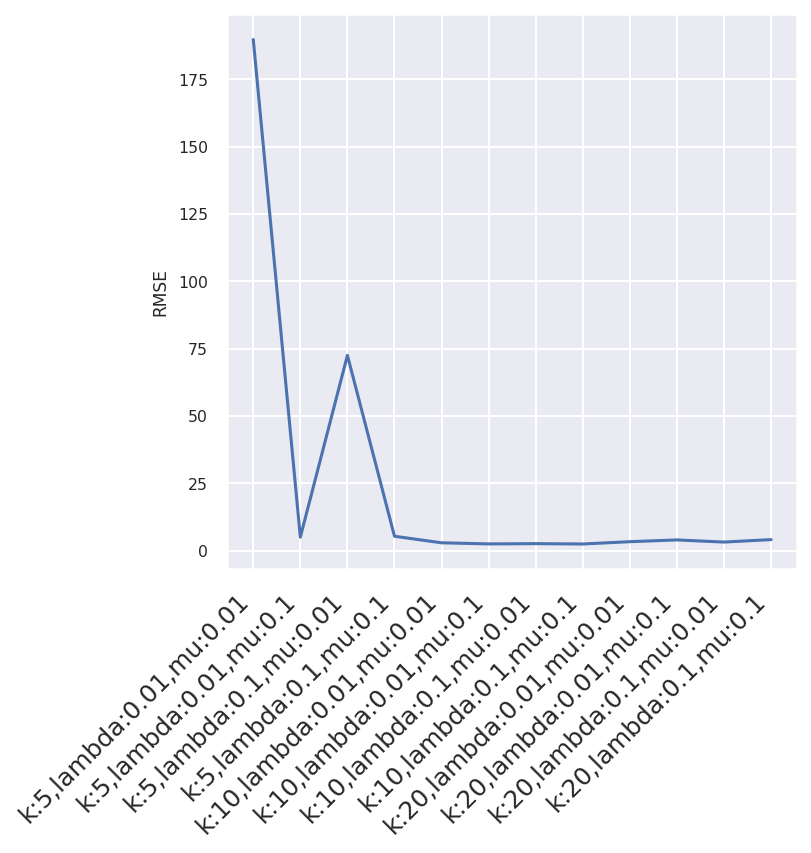

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
gfg = sns.lineplot(x=val_losses.keys(),y=val_losses.values(),data=val_losses)

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)

gfg.set_ylabel( "RMSE")


